In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ternary

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'experiments-average/'

# Analysis of Aggregate Results

Generation of graphs and tables are also here.

### Needed Constants and Variables

In [3]:
SURVEY_ZONE_MAPPING = {'30': (2, 2, 0), '22': (3, 1, 2), '2c': (2, 0, 0), '28': (2, 2, 1), '25': (3, 2, 1), '26': (3, 1, 1), '27': (3, 0, 1), '20': (2, 2, 2), '21': (3, 2, 2), '1e': (3, 1, 2), '23': (3, 0, 2), '24': (2, 0, 1), '29': (3, 2, 1), '1a': (3, 1, 3), '0': (1, 0, 3), '3': (3, 1, 0), '2': (3, 2, 0), '5': (1, 0, 0), '1d': (3, 2, 2), '7': (2, 1, 1), '1f': (3, 0, 2), '9': (3, 1, 1), '8': (3, 2, 1), '3a': (3, 1, 3), '1c': (2, 0, 2), '4': (3, 0, 0), 'a': (3, 0, 1), '6': (1, 0, 1), '39': (3, 2, 3), '12': (1, 0, 2), '3b': (3, 0, 3), '1b': (3, 0, 3), 'b': (1, 0, 2), '13': (1, 0, 2), 'd': (3, 2, 2), '11': (1, 0, 3), '10': (1, 0, 3), 'c': (2, 1, 2), '38': (2, 0, 3), '15': (1, 0, 1), '14': (1, 0, 1), '17': (1, 0, 0), 'f': (3, 0, 2), '19': (3, 2, 3), '32': (3, 1, 0), '31': (3, 2, 0), '16': (1, 0, 0), '37': (3, 0, 3), '36': (3, 1, 3), '35': (3, 2, 3), '34': (2, 1, 3), '2d': (3, 2, 0), '2e': (3, 1, 0), '2f': (3, 0, 0), '1': (2, 1, 0), '2a': (3, 1, 1), '2b': (3, 0, 1), '18': (2, 2, 3), '33': (3, 0, 0), 'e': (3, 1, 2)}

In [125]:
_demands = [
    450,
    900,
    (450, 900),
    (900, 1800)
]

_weights = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.5, 0.5, 0),
    (0, 0.5, 0.5),
    (0.5, 0, 0.5),
    (0.33, 0.33, 0.33),
    (0, 0, 0)
]

_model_type = {
    (1, 0, 0): 'Delay priority',
    (0, 1, 0): 'Throughput priority',
    (0, 0, 1): 'Flow priority',
    (0.5, 0.5, 0): 'Delay-Throughput priority',
    (0, 0.5, 0.5): 'Throughput-Flow priority',
    (0.5, 0, 0.5): 'Delay-Flow priority',
    (0.33, 0.33, 0.33): 'Equal priority',
    (0, 0, 0): 'Parent model',
}

_model_type_cols = [
    'Delay priority',
    'Throughput priority',
    'Flow priority',
    'Delay-Throughput priority',
    'Throughput-Flow priority',
    'Delay-Flow priority',
    'Equal priority',
    'Parent model'
]

_model_type_shorthand = {
    'Delay priority': 'D',
    'Throughput priority': 'T',
    'Flow priority': 'F',
    'Delay-Throughput priority': 'DT',
    'Throughput-Flow priority': 'TF',
    'Delay-Flow priority': 'DF',
    'Equal priority': 'DTF',
    'Parent model': 'Parent'
}

_model_type_shorthand_order = [
    'D', 'T', 'F', 'DT', 'TF', 'DF', 'DTF', 'Parent'
]

In [5]:
_entrance_cols = [(2, 0, 0),     (2, 0, 1),
           (2, 0, 2),     (2, 0, 3),     (2, 1, 0),     (2, 1, 1),
           (2, 1, 2),     (2, 1, 3),     (2, 2, 0),     (2, 2, 1),
           (2, 2, 2),     (2, 2, 3),     (3, 0, 0),     (3, 0, 1),
           (3, 0, 2),     (3, 0, 3),     (3, 1, 0),     (3, 1, 1),
           (3, 1, 2),     (3, 1, 3),     (3, 2, 0),     (3, 2, 1),
           (3, 2, 2),     (3, 2, 3)]

_exit_cols = [(1,0,0), (1,0,1), (1,0,2), (1,0,3)]

In [6]:
PRE_MOVEMENT_APRROACH = {
    'north': [(3,0,0), (3,1,0), (3,2,0)],
    'east': [(3,0,1), (3,1,1), (3,2,1)],
    'south': [(3,0,2), (3,1,2), (3,2,2)],
    'west': [(3,0,3), (3,1,3), (3,2,3)],
}

MOVEMENT_APRROACH = {
    'north': [(2,0,0), (2,1,0), (2,2,0)],
    'east': [(2,0,1), (2,1,1), (2,2,1)],
    'south': [(2,0,2), (2,1,2), (2,2,2)],
    'west': [(2,0,3), (2,1,3), (2,2,3)],
}

MOVEMENT_EXITS_RENAME = {
    (1,0,0): 'north',
    (1,0,1): 'east',
    (1,0,2): 'south',
    (1,0,3): 'west',
}

MOVEMENTS = ['north', 'east', 'south', 'west']

In [7]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 1
}

---

## Loading dataframes

In [9]:
# Results of the MILP solver only (Expected)

df_milp = pd.read_pickle(DF_PATH + 'ave_milp_results.pkl')
df_milp['model_type'] = pd.Categorical(df_milp['model_type'], _model_type_cols)

df_milp.head()

,demand,new_model,alpha,beta,gamma,model_type,epoch,runtime,delay,throughput,objective_value
0,450,False,0.0,0.0,0.0,Parent model,0,370.309661,2313.000000,79.500000,79.500000
1,450,False,0.0,0.0,0.0,Parent model,1,76.772189,6645.796625,127.182068,127.182068
2,450,False,0.0,0.0,0.0,Parent model,2,75.175700,8969.372996,128.522574,128.522574
3,450,False,0.0,0.0,0.0,Parent model,3,79.199085,12726.261603,129.005907,129.005907
4,450,False,0.0,0.0,1.0,Flow priority,0,573.475265,3265.265823,52.278481,-2055.801688


In [10]:
# Results of the LocalSim simulator only (Actual, Aggregate)
# Delay, Throughput

df_ave_delay = pd.read_pickle(DF_PATH + 'agg_ave_delays.pkl')
df_total_delay = pd.read_pickle(DF_PATH + 'agg_total_delays.pkl')
df_total_thru = pd.read_pickle(DF_PATH + 'agg_total_thrus.pkl')

df_aggstd_ave_delay = pd.read_pickle(DF_PATH + 'aggstd_ave_delays.pkl')
# df_total_delay = pd.read_pickle(DF_PATH + 'agg_total_delays.pkl')
df_aggstd_total_thru = pd.read_pickle(DF_PATH + 'aggstd_total_thrus.pkl')

df_ave_delay['model_type'] = pd.Categorical(df_ave_delay['model_type'], _model_type_cols)
df_total_delay['model_type'] = pd.Categorical(df_total_delay['model_type'], _model_type_cols)
df_total_thru['model_type'] = pd.Categorical(df_total_thru['model_type'], _model_type_cols)

df_aggstd_ave_delay['model_type'] = pd.Categorical(df_aggstd_ave_delay['model_type'], _model_type_cols)
df_aggstd_total_thru['model_type'] = pd.Categorical(df_total_thru['model_type'], _model_type_cols)

df_total_thru.head()

level_1,demand,new_model,alpha,beta,gamma,model_type,"(1, 0, 0)","(1, 0, 1)","(1, 0, 2)","(1, 0, 3)"
0,450,False,0.00,0.00,0.00,Parent model,1099.733333,1018.200000,1051.000000,1029.000000
1,450,True,0.00,0.00,1.00,Flow priority,1057.800000,1010.333333,1059.666667,1085.866667
2,450,True,0.00,0.50,0.50,Throughput-Flow priority,1069.733333,1065.200000,1046.266667,1038.333333
3,450,True,0.00,1.00,0.00,Throughput priority,996.133333,1032.600000,998.733333,1069.666667
4,450,True,0.33,0.33,0.33,Equal priority,1055.466667,1070.333333,1009.200000,1040.133333


In [120]:
# Results of the LocalSim simulator only (Actual, Aggregate)
# Speed, Travel Time

df_ave_speed = pd.read_pickle(DF_PATH + 'agg_speeds.pkl')
df_ave_traveltime = pd.read_pickle(DF_PATH + 'agg_traveltimes.pkl')

df_ave_speed['model_type'] = pd.Categorical(df_ave_speed['model_type'], _model_type_cols)
df_ave_traveltime['model_type'] = pd.Categorical(df_ave_traveltime['model_type'], _model_type_cols)

df_ave_speed.head()

,approach,movement,demand,new_model,alpha,beta,gamma,model_type,average_speed
0,East,Left,450,False,0.00,0.00,0.00,Parent model,19.992000
1,East,Left,450,True,0.00,0.00,1.00,Flow priority,13.172000
2,East,Left,450,True,0.00,0.50,0.50,Throughput-Flow priority,15.602000
3,East,Left,450,True,0.00,1.00,0.00,Throughput priority,9.470667
4,East,Left,450,True,0.33,0.33,0.33,Equal priority,8.036000


---

## Plotting Simplex Points and Heatmaps

In [18]:
scale = 1.0
mult = 0.1

df_milp_simplex = pd.read_pickle(DF_PATH + 'results_simplex_d450.pkl')

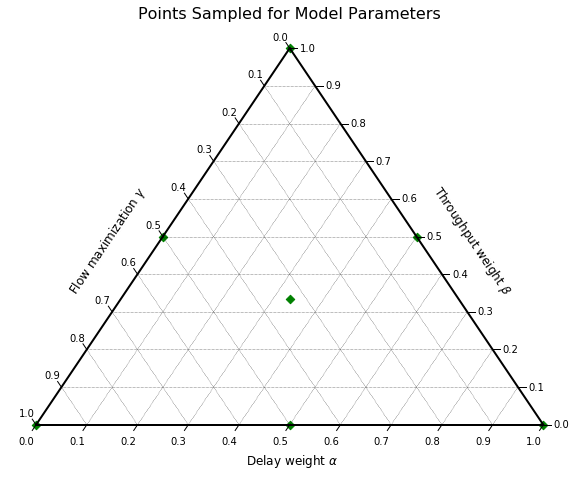

In [12]:
fig, tax = ternary.figure(scale=scale)
fig.set_size_inches(10, 8)

tax.boundary(linewidth=2.0)
tax.gridlines(color="black", multiple=mult)

tax.set_title("Points Sampled for Model Parameters", fontsize=16, pad=15)
tax.bottom_axis_label("Delay weight $\\alpha$", fontsize=12, offset=-0.02)
tax.right_axis_label("Throughput weight $\\beta$", fontsize=12, offset=0.12)
tax.left_axis_label("Flow maximization $\\gamma$", fontsize=12, offset=0.12)

tax.ticks(axis='lbr', linewidth=1, multiple=mult, tick_formats="%.1f", offset=0.015)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax._redraw_labels()

#tax.heatmap(obj_dict, style="triangular", cbarlabel="Computed Objective Value")

point1=[
    (8, 1, 1),
    (1, 8, 1),
    (1, 1, 8),
    (4.5, 4.5, 1),
    (1, 4.5, 4.5),
    (4.5, 1, 4.5),
    (10.0/3.0, 10.0/3.0, 10.0/3.0),
]

point2=[
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.5, 0.5, 0),
    (0, 0.5, 0.5),
    (0.5, 0, 0.5),
    (1.0/3.0, 1.0/3.0, 1.0/3.0)
]
tax.scatter(point2, marker='D', color='green', label=r"$(\frac{1}{3},\frac{2}{3},0)$")

In [65]:
df_nparr = df_milp_simplex.values
delay_dict = {}
thru_dict = {}
runtime_dict = {}
obj_dict = {}
delay_dict_scaled = {}
thru_dict_scaled = {}
runtime_dict_scaled = {}
obj_dict_scaled = {}

for row in df_nparr:
    runtime_dict[(row[-3], row[-2], row[-1])] = row[1]
    delay_dict[(row[-3], row[-2], row[-1])] = row[2]
    thru_dict[(row[-3], row[-2], row[-1])] = row[3]
    obj_dict[(row[-3], row[-2], row[-1])] = row[4]
    runtime_dict_scaled[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[1]
    delay_dict_scaled[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[2]
    thru_dict_scaled[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[3]
    obj_dict_scaled[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[4]

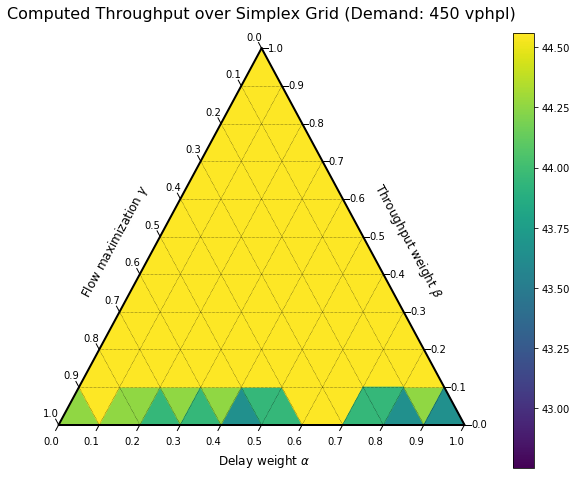

In [86]:
fig, tax = ternary.figure(scale=scale*10)
fig.set_size_inches(10, 8)

tax.boundary(linewidth=2.0)
tax.gridlines(color="black", multiple=mult*10)

tax.set_title("Computed Throughput over Simplex Grid (Demand: 450 vphpl)", fontsize=16, pad=15)
tax.bottom_axis_label("Delay weight $\\alpha$", fontsize=12, offset=-0.02)
tax.right_axis_label("Throughput weight $\\beta$", fontsize=12, offset=0.12)
tax.left_axis_label("Flow maximization $\\gamma$", fontsize=12, offset=0.12)

#tax.ticks(axis='lbr', linewidth=1, multiple=mult*10, tick_formats="%.1f", offset=0.015)
tax.set_axis_limits({
    'l': [0,1.0],
    'b': [0,1.0],
    'r': [0,1.0],
})
tax.get_ticks_from_axis_limits()
tax.set_custom_ticks(linewidth=1, tick_formats="%.1f", offset=0.015)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax._redraw_labels()

tax.heatmap(thru_dict_scaled, style="t")
#tax.scatter(obj_dict.keys(), marker='D', color='green', label=r"$(\frac{1}{3},\frac{2}{3},0)$")

fig.savefig('thru-simplex-new.png')

## Checking average actual delay in the 32 cases

In [12]:
for m in MOVEMENTS:
    df_ave_delay['pre_movement_'+m] = df_ave_delay[PRE_MOVEMENT_APRROACH[m]].sum(axis=1)
    df_ave_delay['movement_'+m] = df_ave_delay[MOVEMENT_APRROACH[m]].mean(axis=1)
    df_ave_delay['delay_'+m] = df_ave_delay['pre_movement_'+m] + df_ave_delay['movement_'+m]

cols = ['demand', 'new_model', 'alpha', 'beta', 'gamma', 'model_type', 'delay_north', 'delay_east', 'delay_south', 'delay_west']
delay_cols = ['delay_north', 'delay_east', 'delay_south', 'delay_west']

df_ave_delay['average_delay'] = df_ave_delay[delay_cols].mean(axis=1)
df_ave_delay['std_delay'] = df_ave_delay[delay_cols].std(axis=1)

### Average delay per vehicle (seconds)

In [13]:
df_ave_delay_table = df_ave_delay.pivot(index='demand', columns='model_type', values='average_delay')[_model_type_cols]
df_ave_delay_table.round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,29.53,44.34,39.81,31.55,34.71,36.52,34.05,39.11
900,58.34,59.09,59.11,58.68,60.27,59.02,58.12,62.01
"(450, 900)",46.71,47.14,45.49,46.02,45.64,45.83,45.99,81.87
"(900, 1800)",60.76,60.16,61.33,60.61,60.30,60.55,60.33,161.23


**Standard deviation across runs of average delay**

In [33]:
df_aggstd_ave_delay_table = df_aggstd_ave_delay.pivot(index='demand', columns='model_type', values='average_delay')[_model_type_cols]
df_aggstd_ave_delay_table.round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,5.20,3.78,2.67,3.84,2.85,2.99,3.07,3.85
900,1.04,1.10,1.22,0.87,0.78,0.79,1.16,1.42
"(450, 900)",2.14,2.27,1.99,1.47,2.12,2.42,2.12,5.48
"(900, 1800)",0.89,1.01,0.74,1.06,0.68,1.22,1.03,17.51


**Hypothesis test for 2 means**

In [85]:
# Difference between F and TF (overasym) significant?
xmean = 60.16
ymean = 60.76
d = 0
xstd = 1.01
ystd = 0.89
xn = 15
yn = 15

# X - Y < d?

import math

T = (xmean - ymean - d) / (math.sqrt( ((xstd**2) / (xn)) + ((ystd**2) / (yn)) ))
print(T)
print(abs(T) > Tav)
Tav = 1.761310
Taveq = 2.14479
# T > T(0.05,14)? YES
# T(0.05,14) = 1.761310

-1.72621075008
False


So far:

* Difference between Parent model and D (900) is significant
* Difference between Parent model and TF (900) is significant
* Difference between D and TF (900) is significant
* Increase from F to T (450,900) is significant
* Increase from TF to F (900,1800) is significant

### Percent improvement of delay from parent model

In [31]:
df_ave_delay_percent = (df_ave_delay_table.iloc[:, :-1] - df_ave_delay_table[['Parent model']].values) * -100 / df_ave_delay_table[['Parent model']].values
df_ave_delay_percent.round(0)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority
demand,,,,,,,
450,24.0,-13.0,-2.0,19.0,11.0,7.0,13.0
900,6.0,5.0,5.0,5.0,3.0,5.0,6.0
"(450, 900)",43.0,42.0,44.0,44.0,44.0,44.0,44.0
"(900, 1800)",62.0,63.0,62.0,62.0,63.0,62.0,63.0


### Standard deviation across approaches* of delay per vehicle (seconds)

In [15]:
df_std_delay_table = df_ave_delay.pivot(index='demand', columns='model_type', values='std_delay')[_model_type_cols]
df_std_delay_table.round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,2.22,11.05,10.26,10.87,1.95,21.24,20.07,18.53
900,1.46,10.89,5.89,3.02,7.71,3.25,1.49,9.16
"(450, 900)",27.38,11.16,19.05,28.77,21.25,21.48,28.09,52.80
"(900, 1800)",9.96,5.47,9.78,5.22,6.34,9.46,8.17,152.72


---

## Checking total actual delay in the 32 cases (vehicle-hours)

In [16]:
for m in MOVEMENTS:
    df_total_delay['delay_'+m] = df_total_delay[PRE_MOVEMENT_APRROACH[m] + MOVEMENT_APRROACH[m]].sum(axis=1)

delay_cols = ['delay_north', 'delay_east', 'delay_south', 'delay_west']

df_total_delay['total_delay'] = df_total_delay[delay_cols].sum(axis=1)
df_total_delay['ave_approach_delay'] = df_total_delay[delay_cols].mean(axis=1)
df_total_delay['std_approach_delay'] = df_total_delay[delay_cols].std(axis=1)

### Total delay in the intersection (vehicle-hours)

In [17]:
df_total_delay_table = df_total_delay.pivot(index='demand', columns='model_type', values='total_delay')[_model_type_cols]
df_total_delay_table.apply(lambda x: x / 3600).round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,26.20,28.81,28.02,26.99,27.67,28.86,25.60,24.24
900,75.84,75.97,76.04,76.19,75.77,75.00,75.80,70.98
"(450, 900)",48.13,51.73,50.22,47.71,50.34,47.41,47.69,47.95
"(900, 1800)",79.19,81.69,80.92,79.46,80.55,79.29,79.33,58.23


---

## Checking average actual throughput in the 32 cases

In [42]:
df_total_thru['total_throughput'] = df_total_thru[_exit_cols].sum(axis=1)
df_total_thru['ave_throughput'] = df_total_thru[_exit_cols].mean(axis=1)
df_total_thru['std_throughput'] = df_total_thru[_exit_cols].std(axis=1)
df_total_thru = df_total_thru.rename(columns=MOVEMENT_EXITS_RENAME)

### Total throughput of the intersection (vehicles)

In [43]:
df_total_thru_table = df_total_thru.pivot(index='demand', columns='model_type', values='total_throughput')[_model_type_cols]
df_total_thru_table.round(0)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,4218.0,4097.0,4214.0,4236.0,4220.0,4192.0,4175.0,4198.0
900,5980.0,5910.0,6004.0,5957.0,6095.0,5977.0,5954.0,6334.0
"(450, 900)",5056.0,5370.0,5150.0,5051.0,5101.0,5263.0,5099.0,5542.0
"(900, 1800)",6799.0,6727.0,6775.0,6790.0,6692.0,6782.0,6775.0,6924.0


**Standard deviation across runs of total throughput**

In [45]:
df_aggstd_total_thru_table = df_aggstd_total_thru.pivot(index='demand', columns='model_type', values='total_throughput')[_model_type_cols]
df_aggstd_total_thru_table.round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,137.16,146.48,139.57,102.58,152.52,116.99,145.01,117.83
900,100.68,87.43,98.02,117.46,99.55,110.42,121.84,73.11
"(450, 900)",79.09,104.57,92.62,113.19,101.75,116.16,161.26,127.83
"(900, 1800)",66.41,76.72,114.15,68.50,56.72,86.31,93.97,101.95


**Hypothesis test for 2 means**

In [94]:
# Difference between D and TF (overasym) significant?
xmean = 6799
ymean = 6727
d = 0
xstd = 66.41
ystd = 76.72
xn = 15
yn = 15

# X - Y != d?

import math

T = (xmean - ymean - d) / (math.sqrt( ((xstd**2) / (xn)) + ((ystd**2) / (yn)) ))
print(T)
print(T > Tav)
Tav = 1.761310
Taveq = 2.14479
# T > T(0.05,14)? YES
# T(0.05,14) = 1.761310

2.74813877763
True


_450_
* DT's improvement over the Parent is NOT significant
* DT's improvement over T is significant

_900_
* Parent's difference over TF is significant
* TF's difference over T is significant

_450, 900_
* Parent's difference over T is significant
* T's difference over DT is significant

_900, 1800_
* Parent's difference over D is significant
* D's difference over TF is significant

### Percent improvement of throughput from parent model

In [20]:
df_total_thru_percent = (df_total_thru_table.iloc[:, :-1] - df_total_thru_table[['Parent model']].values) * 100 / df_total_thru_table[['Parent model']].values
df_total_thru_percent.round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority
demand,,,,,,,
450,0.47,-2.40,0.37,0.91,0.51,-0.14,-0.54
900,-5.59,-6.71,-5.21,-5.96,-3.78,-5.64,-6.00
"(450, 900)",-8.77,-3.10,-7.06,-8.85,-7.95,-5.02,-7.98
"(900, 1800)",-1.81,-2.84,-2.15,-1.93,-3.35,-2.04,-2.15


### Average total throughput per approach (vehicles)

In [21]:
df_total_thru_table = df_total_thru.pivot(index='demand', columns='model_type', values='ave_throughput')[_model_type_cols]
df_total_thru_table.round(0)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,1054.0,1024.0,1053.0,1059.0,1055.0,1048.0,1044.0,1049.0
900,1495.0,1477.0,1501.0,1489.0,1524.0,1494.0,1488.0,1584.0
"(450, 900)",1264.0,1343.0,1288.0,1263.0,1275.0,1316.0,1275.0,1385.0
"(900, 1800)",1700.0,1682.0,1694.0,1698.0,1673.0,1696.0,1694.0,1731.0


### Standard deviation across approaches* of throughput (vehicles)

In [22]:
df_total_thru_table = df_total_thru.pivot(index='demand', columns='model_type', values='std_throughput')[_model_type_cols]
df_total_thru_table.round(0)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,23.0,35.0,31.0,9.0,15.0,23.0,26.0,36.0
900,54.0,129.0,35.0,7.0,62.0,36.0,41.0,89.0
"(450, 900)",58.0,62.0,53.0,54.0,75.0,13.0,60.0,87.0
"(900, 1800)",295.0,267.0,241.0,329.0,299.0,311.0,248.0,243.0


---

## Checking travel time of the 32 cases, for each of the movements / approaches

### Average across movements (symmetric)

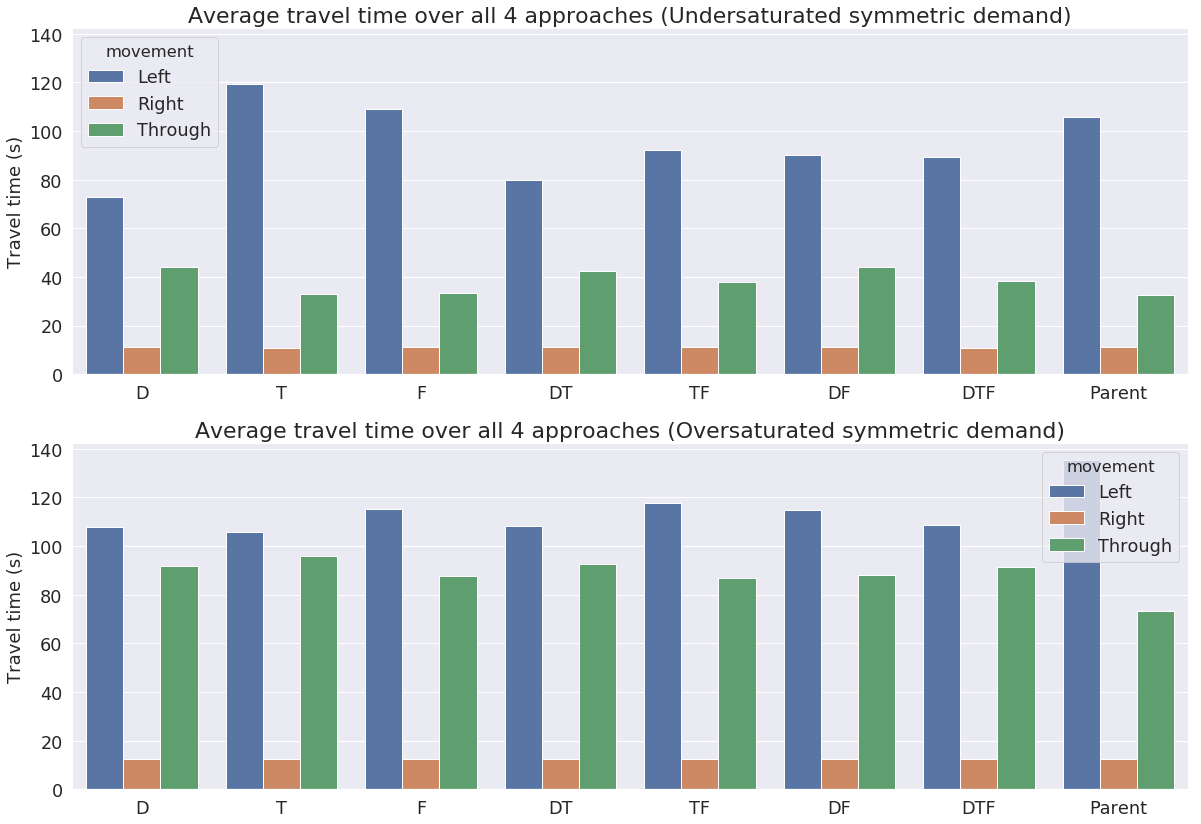

In [137]:
df_ave_traveltime_movements = df_ave_traveltime.groupby(['demand', 'model_type', 'movement']).agg({'travel_time': 'mean'}).reset_index()
df_ave_traveltime_movements = df_ave_traveltime_movements.replace(_model_type_shorthand)
df_ave_traveltime_450 = df_ave_traveltime_movements[df_ave_traveltime_movements['demand'] == 450]
df_ave_traveltime_900 = df_ave_traveltime_movements[df_ave_traveltime_movements['demand'] == 900]

fig, axs = plt.subplots(2,1,figsize=(20,14),sharey=True)

sns.set(font_scale = 1.6)
sns.barplot(data=df_ave_traveltime_450, x='model_type', y='travel_time', hue='movement', ax=axs[0])

axs[0].set_title('Average travel time over all 4 approaches (Undersaturated symmetric demand)', fontsize=22)
axs[0].set_xlabel('')
axs[0].set_ylabel('Travel time (s)', fontsize=18)

sns.barplot(data=df_ave_traveltime_900, x='model_type', y='travel_time', hue='movement', ax=axs[1])

axs[1].set_title('Average travel time over all 4 approaches (Oversaturated symmetric demand)', fontsize=22)
axs[1].set_xlabel('')
axs[1].set_ylabel('Travel time (s)', fontsize=18)

plt.savefig('ave-traveltime-symmetric.png')

### Comparison between approaches (demand: (450, 900))

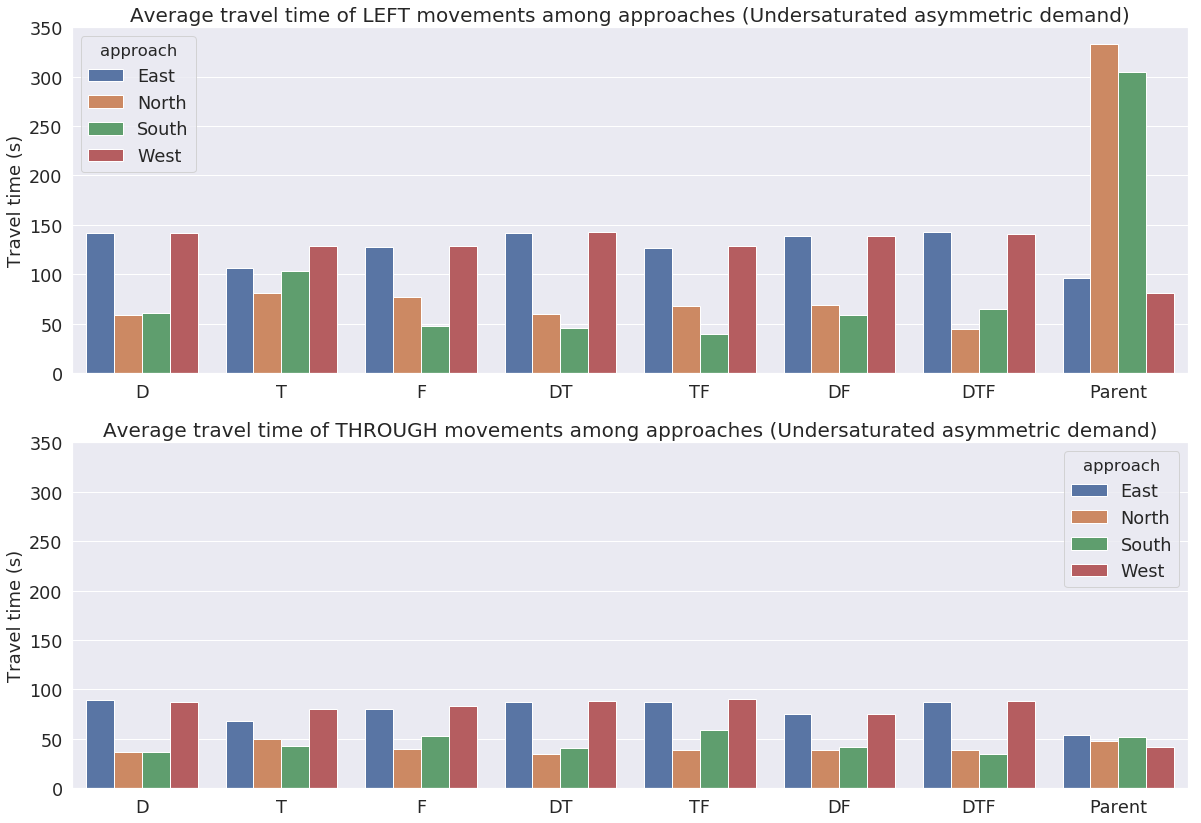

In [128]:
demand_tmp = (450, 900)

df_ave_traveltime_left = df_ave_traveltime[(df_ave_traveltime['demand'] == demand_tmp) & (df_ave_traveltime['movement'] == 'Left')].replace(_model_type_shorthand)
df_ave_traveltime_thru = df_ave_traveltime[(df_ave_traveltime['demand'] == demand_tmp) & (df_ave_traveltime['movement'] == 'Through')].replace(_model_type_shorthand)

fig, axs = plt.subplots(2,1,figsize=(20,14),sharey=True)

sns.set(font_scale = 1.6)
sns.barplot(data=df_ave_traveltime_left, x='model_type', y='travel_time', hue='approach', ax=axs[0], order=_model_type_shorthand_order)

axs[0].set_title('Average travel time of LEFT movements among approaches (Undersaturated asymmetric demand)', fontsize=20)
axs[0].set_ylabel('Travel time (s)', fontsize=18)
axs[0].set_xlabel('')

sns.barplot(data=df_ave_traveltime_thru, x='model_type', y='travel_time', hue='approach', ax=axs[1], order=_model_type_shorthand_order)

axs[1].set_title('Average travel time of THROUGH movements among approaches (Undersaturated asymmetric demand)', fontsize=20)
axs[1].set_ylabel('Travel time (s)', fontsize=18)
axs[1].set_xlabel('')

plt.savefig('ave-traveltime-underasymm.png')

### Comparison between approaches (demand: (900, 1800))

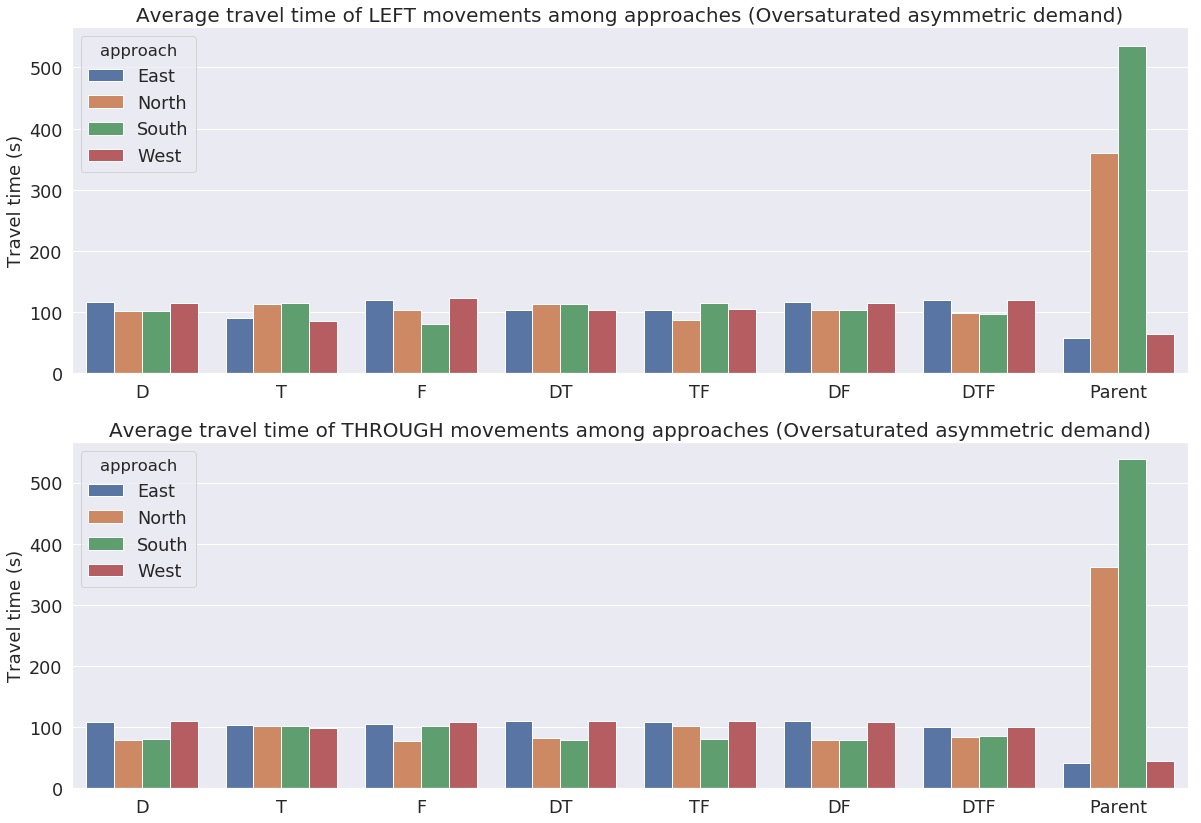

In [136]:
demand_tmp = (900, 1800)

df_ave_traveltime_left = df_ave_traveltime[(df_ave_traveltime['demand'] == demand_tmp) & (df_ave_traveltime['movement'] == 'Left')].replace(_model_type_shorthand)
df_ave_traveltime_thru = df_ave_traveltime[(df_ave_traveltime['demand'] == demand_tmp) & (df_ave_traveltime['movement'] == 'Through')].replace(_model_type_shorthand)

fig, axs = plt.subplots(2,1,figsize=(20,14),sharey=True)

sns.set(font_scale = 1.6)
sns.barplot(data=df_ave_traveltime_left, x='model_type', y='travel_time', hue='approach', ax=axs[0], order=_model_type_shorthand_order)

axs[0].set_title('Average travel time of LEFT movements among approaches (Oversaturated asymmetric demand)', fontsize=20)
axs[0].set_ylabel('Travel time (s)', fontsize=18)
axs[0].set_xlabel('')

sns.barplot(data=df_ave_traveltime_thru, x='model_type', y='travel_time', hue='approach', ax=axs[1], order=_model_type_shorthand_order)

axs[1].set_title('Average travel time of THROUGH movements among approaches (Oversaturated asymmetric demand)', fontsize=20)
axs[1].set_ylabel('Travel time (s)', fontsize=18)
axs[1].set_xlabel('')

plt.savefig('ave-traveltime-overasymm.png')

## Checking initial computation runtime in the 32 cases (seconds)

In [27]:
df_milp[df_milp.epoch == 0].pivot(index='demand', columns='model_type', values='runtime')[_model_type_cols].round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,165.90,268.79,573.48,475.49,293.79,540.86,752.90,370.31
900,5.30,284.86,617.50,6.77,292.91,8.85,10.81,200.26
"(450, 900)",40.05,104.16,151.78,48.29,134.06,51.76,86.14,87.43
"(900, 1800)",2.31,48.83,80.19,2.36,47.80,2.70,2.57,13.58


## Checking recomputation runtime in the 32 cases (average across epochs) (seconds)

In [28]:
df_milp[df_milp.epoch != 0].pivot_table(index='demand', columns='model_type', values='runtime', aggfunc='mean')[_model_type_cols].round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,2.02,0.68,0.50,1.93,0.72,2.06,1.99,77.05
900,1.84,0.60,0.43,1.75,0.95,1.80,1.77,78.61
"(450, 900)",1.99,0.63,0.46,1.93,0.72,2.01,1.99,81.81
"(900, 1800)",1.62,0.62,0.40,1.71,0.69,1.78,1.76,77.23


---

## Plot of cumulative delay (lower curve is better)

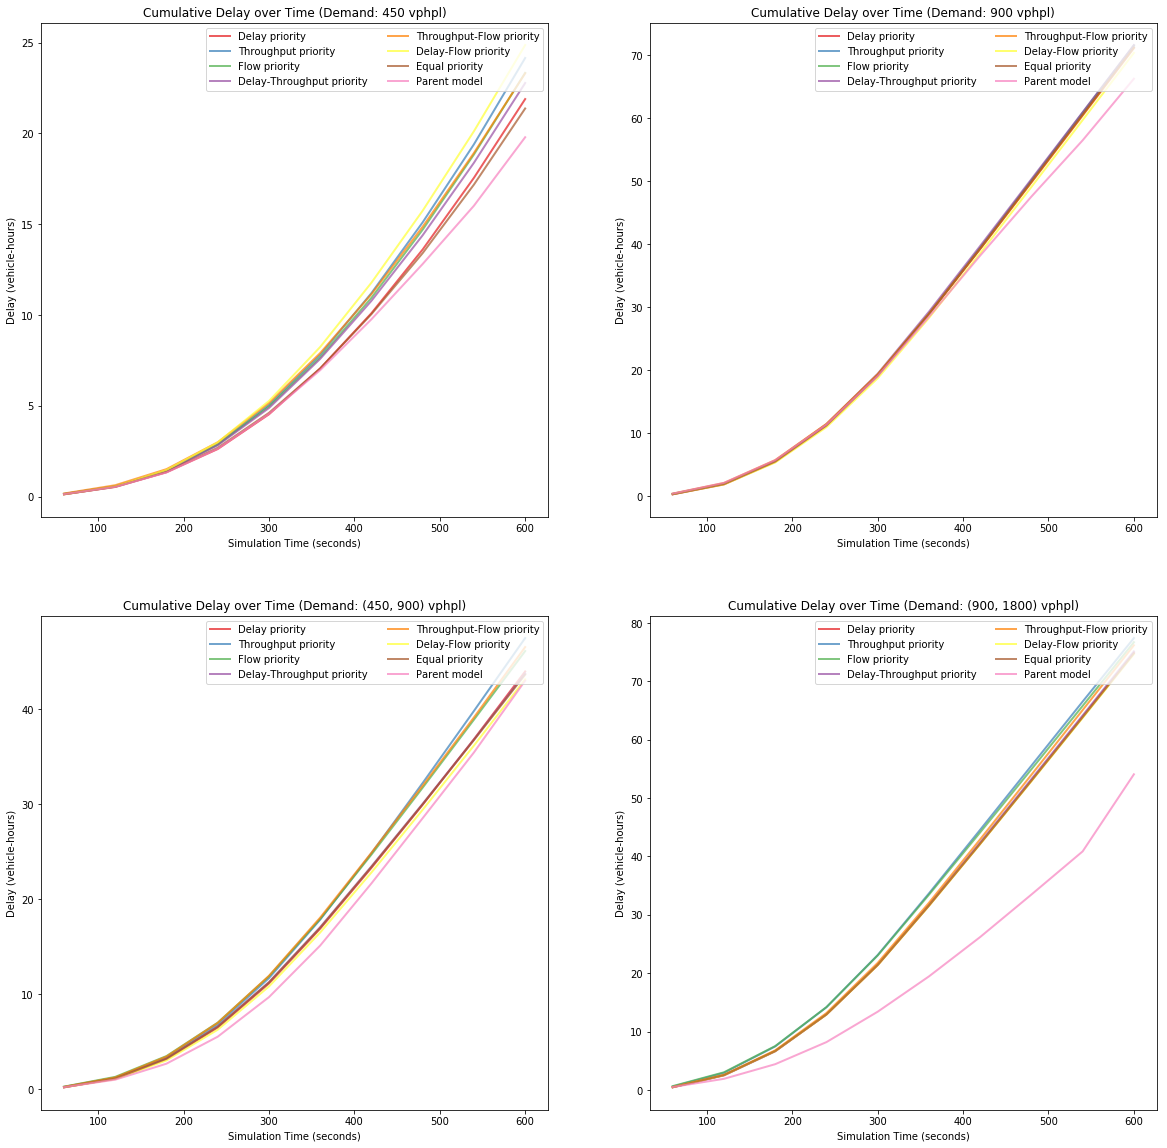

In [29]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumudelays = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-delays/delays_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumudelays[_model_type[weights]] = df_tmp.iloc[:, 4:].sum(axis=1).apply(lambda x: x / 3600)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumudelays:
        axs[ndx / 2, ndx % 2].plot(df_cumudelays.index, df_cumudelays[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Delay over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Delay (vehicle-hours)")

## Plot of cumulative throughput (higher is better)

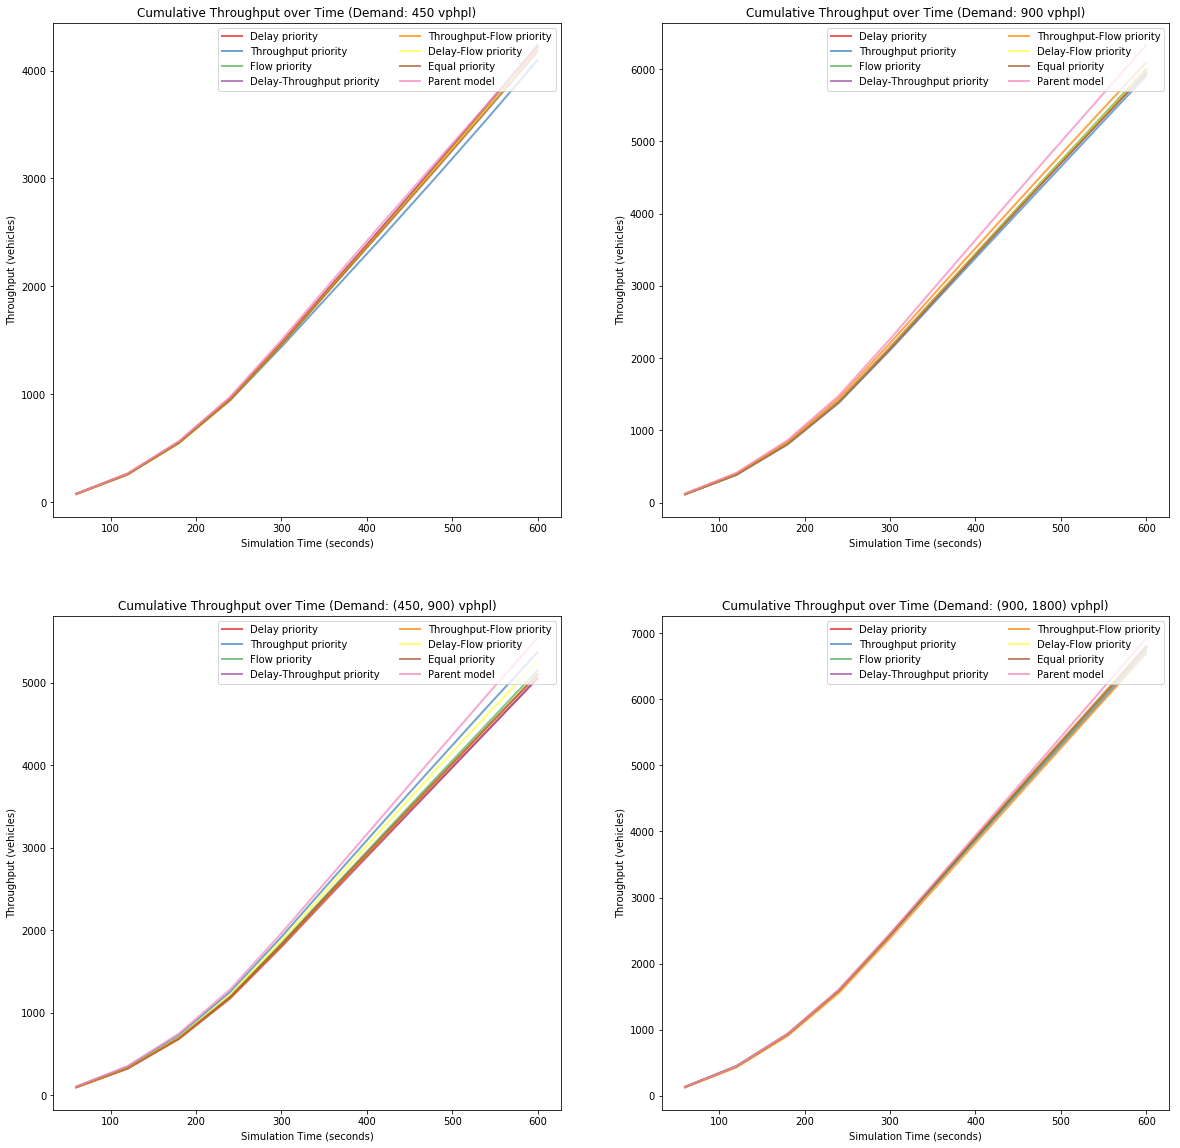

In [30]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumuthrus = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-thrus/thrus_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumuthrus[_model_type[weights]] = df_tmp.sum(axis=1)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumuthrus:
        axs[ndx / 2, ndx % 2].plot(df_cumuthrus.index, df_cumuthrus[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Throughput over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Throughput (vehicles)")